1. https://data.caltech.edu/records/20098
2. https://www.kaggle.com/code/anuragmishra2311/birds-classification-using-resnet-101/notebook
3. https://www.kaggle.com/datasets/gpiosenka/100-bird-species

In [39]:
import os
import shutil
import tensorflow as tf
import pandas as pd
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Conv2D,MaxPool2D,Flatten,Dropout,BatchNormalization,Activation
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img,img_to_array
from tensorflow.keras.applications import ResNet101V2

In [40]:
train_directory='../../../../../DataSets/IMG-100/train'
val_directory='../../../../../DataSets/IMG-100/valid'
test_directory='../../../../../DataSets/IMG-100/test'

In [41]:
train_datagen=ImageDataGenerator(rescale=1/255)
val_datagen=ImageDataGenerator(rescale=1/255)
test_datagen=ImageDataGenerator(rescale=1/255)

In [42]:
train_generator=train_datagen.flow_from_directory(train_directory,
                                                 target_size=(224,224),
                                                 color_mode='rgb',
                                                 class_mode='sparse',batch_size=256)

val_generator=val_datagen.flow_from_directory(val_directory,
                                                 target_size=(224,224),
                                                 color_mode='rgb',
                                                 class_mode='sparse',batch_size=256)
                                                 
                                                 
test_gemerator=test_datagen.flow_from_directory(test_directory,
                                                 target_size=(224,224),
                                                 color_mode='rgb',
                                                 class_mode='sparse',batch_size=256)

Found 822 images belonging to 6 classes.
Found 30 images belonging to 6 classes.
Found 30 images belonging to 6 classes.


In [43]:
train_generator.class_indices;

In [44]:
convlayer=ResNet101V2(input_shape=(224,224,3),weights='imagenet',include_top=False)
for layer in convlayer.layers:
    layer.trainable=False

In [45]:
model = Sequential()
model.add(convlayer)
model.add(Dropout(0.5))
model.add(Flatten())
model.add(BatchNormalization())
model.add(Dense(2048, kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(1024, kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(225, activation='softmax'))
print(model.summary())


Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet101v2 (Functional)    (None, 7, 7, 2048)        42626560  
                                                                 
 dropout_12 (Dropout)        (None, 7, 7, 2048)        0         
                                                                 
 flatten_4 (Flatten)         (None, 100352)            0         
                                                                 
 batch_normalization_12 (Bat  (None, 100352)           401408    
 chNormalization)                                                
                                                                 
 dense_12 (Dense)            (None, 2048)              205522944 
                                                                 
 batch_normalization_13 (Bat  (None, 2048)             8192      
 chNormalization)                                     

In [46]:
opt=tf.keras.optimizers.Adam(lr=0.001)
model.compile(loss='sparse_categorical_crossentropy',metrics=['accuracy'],optimizer=opt)

In [47]:
history = model.fit(train_generator, validation_data=val_generator,
                    epochs=5)


Epoch 1/5
4/4 [==============================] - 134s 39s/step - loss: 2.1868 - accuracy: 0.6350 - val_loss: 18.8240 - val_accuracy: 0.4000
Epoch 2/5
4/4 [==============================] - 121s 28s/step - loss: 0.1482 - accuracy: 0.9769 - val_loss: 13.5432 - val_accuracy: 0.5000
Epoch 3/5
4/4 [==============================] - 125s 29s/step - loss: 0.0171 - accuracy: 0.9964 - val_loss: 6.7401 - val_accuracy: 0.7333
Epoch 4/5
4/4 [==============================] - 122s 28s/step - loss: 0.0071 - accuracy: 0.9988 - val_loss: 3.5255 - val_accuracy: 0.7667
Epoch 5/5
4/4 [==============================] - 124s 29s/step - loss: 0.0031 - accuracy: 1.0000 - val_loss: 1.5687 - val_accuracy: 0.8000


In [48]:
opt = tf.keras.optimizers.RMSprop(lr=0.0001)
model.compile(loss='sparse_categorical_crossentropy',
              metrics=['accuracy'], optimizer=opt)
history_1 = model.fit(train_generator, validation_data=val_generator,
                      epochs=1)


c:\ProgramData\Miniconda3\envs\dbsenvalt\lib\site-packages\keras\optimizer_v2\rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


4/4 [==============================] - 136s 30s/step - loss: 0.0017 - accuracy: 1.0000 - val_loss: 0.6439 - val_accuracy: 0.8333


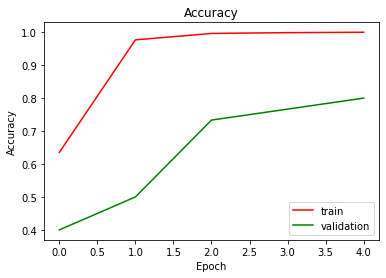

In [49]:
plt.plot(history.history['accuracy'],c='red')
plt.plot(history.history['val_accuracy'],c='green')
plt.title('Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train','validation'],loc='lower right')

In [50]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

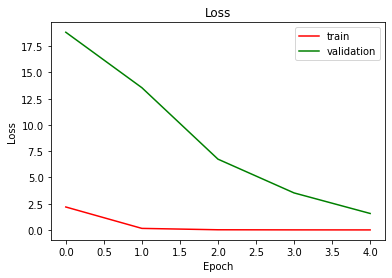

In [51]:
plt.plot(history.history['loss'],c='red')
plt.plot(history.history['val_loss'],c='green')
plt.title('Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train','validation'],loc='upper right')

In [52]:
model.evaluate(test_gemerator)


1/1 [==============================] - 5s 5s/step - loss: 1.2503 - accuracy: 0.8667


[1.250303030014038, 0.8666666746139526]

In [102]:
def predict_prob(number):
  return [number[0],1-number[0]]


In [113]:
dic=train_generator.class_indices
icd={k:v for v,k in dic.items()}
def output(location):
    img=load_img(location,target_size=(224,224,3))
    img=img_to_array(img)
    img=img/255
    img=np.expand_dims(img,[0])
    # answer=model.predict_classes(img)
    predict_x=model.predict(img) 
    classes_x=np.argmax(predict_x,axis=1)
    answer = icd[classes_x[0]]
    
    prob = np.array(list(map(predict_prob, model.predict(img))))
    prob = prob[0].flatten()
    prob = prob[0] * 100
    print (prob, ' % chances are there that the Bird Is',answer)

100.0  % chances are there that the Bird Is ANNAS HUMMINGBIRD


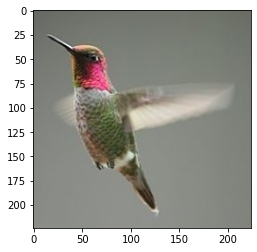

In [114]:
img='../../../../../DataSets/IMG-100/images to test/1.jpg'
pic=load_img('../../../../../DataSets/IMG-100/images to test/1.jpg',target_size=(224,224,3))
plt.imshow(pic)
output(img)

6.307530053817345e-08  % chances are there that the Bird Is BARN OWL


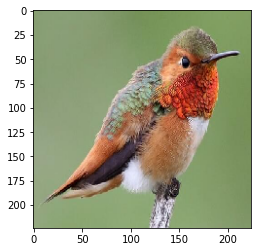

In [115]:
img='../../../../../DataSets/IMG-100/images to test/2.jpg'
pic=load_img('../../../../../DataSets/IMG-100/images to test/2.jpg',target_size=(224,224,3))
plt.imshow(pic)
output(img)

0.44474927708506584  % chances are there that the Bird Is BARN OWL


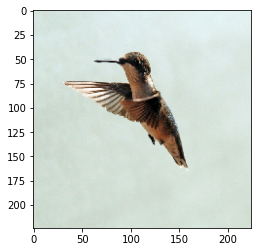

In [116]:
img='../../../../../DataSets/IMG-100/images to test/3.jpg'
pic=load_img('../../../../../DataSets/IMG-100/images to test/3.jpg',target_size=(224,224,3))
plt.imshow(pic)
output(img)